# 2. Fourier spectral
This notebook demonstrates solving the 1D Burgers Equation using the Fourier Galerkin and Fourier pseudospectral methods implemented based on Basdevant1986.

We'll go over the following:
- How I apply Fourier spectral methods to the 1D Burgers equation
- Some example results from my implementation

A more thorough study of the performance is saved for the comparison between methods.


In [20]:
using Pkg
Pkg.activate("..") # activate BurgersJoint environment
Pkg.instantiate() # install all dependencies if necessary
using BurgersJoint
using BurgersJoint.BurgersEquation
using BurgersJoint.FourierSpectral
using Plots

  Activating project at `~/Documents/ACFPD/Individual assignment/BurgersJoint`


## Fourier spectral methods for the 1D Burgers equation
The 1D Burgers equation is given by
$$
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}
$$
where $u$ is the velocity field, $\nu$ is the kinematic viscosity, and $x$ is the spatial coordinate. We consider this problem defined for $t \in [0, T]$ and $x \in [-1, 1]$ with initial condition $u(0, x) = -\sin(\pi x)$ and periodic boundary conditions. The Fourier spectral method approximates the solution using a Fourier series expansion in space, such as:
$$
u(x, t) = \sum_{j=-N/2 + 1}^{N/2} \hat{u}_k(t) e^{i k_j x},\quad k_j = \frac{2 \pi j}{L}
$$
where $\hat{u}_k(t)$ are the Fourier coefficients, $N$ is the number of grid points (assumed even for this example), and $\left\{k_j\right\}$ are the angular wavenumbers. This form is inherently periodic, which is a requirement for the Fourier spectral method. As for this project we are considering a periodic problem, we can use the Fourier spectral methods. The Fourier coefficients can be computed using the Fast Fourier Transform (FFT) algorithm, where they are given by:
$$
\hat{u}_k(t) = \sum_{j=-N/2 + 1}^{N/2} u_j(t) e^{-i k x_j},\quad x_j = \frac{L j}{N}
$$
This expansion of the solution allows us to perform time integration in the Fourier space, which is often more efficient than in real space, especially for nonlinear problems like the Burgers equation. To see why, let us first apply a Fourier transform to the PDE.

### Solution of Burgers' equation in Fourier space
Relevant derivatives are:
$$
\mathcal{F}\big[u(x,t)\big] = \hat{u}(k,t),\quad \mathcal{F}\big[\partial_t u\big] = \partial_t \hat{u},\quad \mathcal{F}\big[\partial_x u\big] = i\,k\,\hat{u},\quad \mathcal{F}\big[\partial_x^2 u\big] = -k^2\,\hat{u},
$$
$$
\mathcal{F}\!\left[u\,\partial_x u\right] = \mathcal{F}\!\left[\frac{1}{2} \partial_x u^2\right] = \frac{ik}{2} \mathcal{F}\!\left[u^2\right]\,.
$$
Burgers' equation reads

$$
\partial_t u + u\,\partial_x u = \nu\,\partial_x^2 u\,.
$$

Taking the Fourier transform term‐by‐term, we obtain

$$
\partial_t \hat{u}(k,t) + \frac{ik}{2} \mathcal{F}\!\left[u^2\right](k,t) = -\nu\,k^2\,\hat{u}(k,t)\,.
$$

We cannot further simplify this equation, as the term $\mathcal{F}\!\left[u^2\right]$ is not known. We can however solve the equation numerically by using the Fourier pseudospectral method and evaluating the term $\mathcal{F}\!\left[u^2\right]$ in real space. We can do this by first finding the real space solution $u(x,t)$ from the Fourier coefficients $\hat{u}(k,t)$, then evaluating $u^2(x,t)$ in real space, and finally taking the Fourier transform of $u^2(x,t)$ to find $\mathcal{F}\!\left[u^2\right]$.

### Numerical time-stepping scheme

To solve the equation numerically, we can use a time-stepping scheme. For the first half-step we'll use a first-order (Euler) approximation, which updates the solution as follows:
$$
\hat{u}(k,t+\Delta t) = e^{-\nu k^2 \Delta t} \hat{u}(k,t) - \Delta t e^{-\nu k^2 \Delta t} \frac{ik}{2} \mathcal{F}\!\left[u^2\right](k,t) = e^{-\nu k^2 \Delta t} \left[\hat{u}(k,t) - \Delta t\ \frac{ik}{2} \mathcal{F}\!\left[u^2\right](k,t)\right]\,.
$$
For subsequent half-steps, we use the Leapfrog-like scheme from Basdevant1986:
$$
\hat{u}(k,t+\Delta t) = e^{-2\nu k^2 \Delta t} \hat{u}(k,t-\Delta t) - 2\Delta t e^{-\nu k^2 \Delta t} \frac{ik}{2}  \mathcal{F}\!\left[u^2\right](k,t)\,.
$$
This scheme should be second-order accurate in time and unconditionally stable for the viscous terms.

### Galerkin vs. pseudospectral

The Fourier expansion terms for $k_j=2 \pi j/L$ with $|j|\geq N/3$ introduce aliasing errors. Truncating the Fourier series to $|j| < N/3$ to avoid aliasing error and using the remaining terms to approximate the solution is called the Galerkin method. The Fourier pseudospectral method, on the other hand, uses all Fourier modes, leading to aliasing error.

To be consistent with Basdevant, we introduce the dealiasing factor $\alpha$ as
$$
\alpha = j_\mathrm{cut} / j_\mathrm{max} = 2/3,
$$ 
where $j_\mathrm{cut}$ is the cutoff wavenumber and $j_\mathrm{max}$ is the maximum wavenumber ($N/2$ for even $N$). The dealiasing factor is used to truncate the Fourier series to avoid aliasing errors. The Fourier coefficients are then given by:
$$
\hat{u}_k(t) = \begin{cases}
\hat{u}_k(t) & \text{if } |k| < \alpha N/2\\
0 & \text{if } |k| \geq \alpha N/2
\end{cases}
$$
For the Galerkin scheme, dealiasing is always done before evaluating the solution in real space from the Fourier coefficients.

### Summary of the algorithm

The algorithm for solving Burgers' equation with Fourier spectral methods is as follows:
1. Determine the initial real-space solution $u(x,0)$.
2. Perform DFT to find the initial Fourier coefficients $\hat{u}(k,0)$.
3. Time-stepping loop for $t = 0, \Delta t, \ldots, T$:
    1. Calculate $\mathcal{F}\!\left[u^2\right]$ from the real-space solution.
    2. Find $\hat{u}(k,t+\Delta t)$ from $\hat{u}(k,t)$ using the above update rule.
    3. Apply dealiasing to $\hat{u}(k,t+\Delta t)$ (only for the Galerkin method).
    4. Perform inverse DFT to find the real-space solution $u(x,t+\Delta t)$.

I invite you to check the implementation in `FourierSpectral.py` in the `src/methods` folder, where I explain the code in detail.

## Example results
Let us look at a few example solutions using the Fourier spectral methods. We will use the following parameters unless otherwise specified:
- Domain $x\in[-1,1]$
- Viscosity $\nu = 10^{-2}/\pi$
- Initial condition $u(x,0) = -\sin(x)$
- Number of grid points $N = 128$
- Time step $\Delta t = 0.001$
- Total time $T = 4/\pi$

#### Fourier Galerkin example

Set parameters and run solver:

In [21]:
# Parameter choices:
N   = 128
dt = 1e-3
T   = 4/pi
dt_snapshot = 1/pi # time between solution snapshots

x, u_final, snapshot_times, snapshots = solveFourierSpectral(N; dt=dt, T=T, dt_snapshot=dt_snapshot, dealias_factor=2/3)

(-0.984375:0.015625:1.0, [0.0005461620797875821, 0.028456810825054746, 0.030247340815682144, 0.029618666999834842, 0.05739175190628737, 0.06046690384676115, 0.05875724820521305, 0.08626858426361561, 0.09063713598729128, 0.08795325838203749  …  -0.09063713598729123, -0.08626858426361522, -0.058757248205212664, -0.06046690384676118, -0.0573917519062872, -0.02961866699983462, -0.030247340815682255, -0.0284568108250548, -0.0005461620797876376, -1.0815797607250623e-16], [0.0, 0.318, 0.637, 0.9550000000000001, 1.2730000000000001], [[0.049067674327418015, 0.0980171403295606, 0.14673047445536175, 0.19509032201612828, 0.2429801799032639, 0.2902846772544624, 0.33688985339222005, 0.3826834323650898, 0.4275550934302821, 0.47139673682599764  …  -0.4275550934302821, -0.3826834323650898, -0.33688985339222005, -0.2902846772544624, -0.2429801799032639, -0.19509032201612828, -0.14673047445536175, -0.0980171403295606, -0.049067674327418015, -0.0], [0.022800778537078487, 0.05059134174742441, 0.07360594390

Plot numerical solution versus analytical solution at different times:

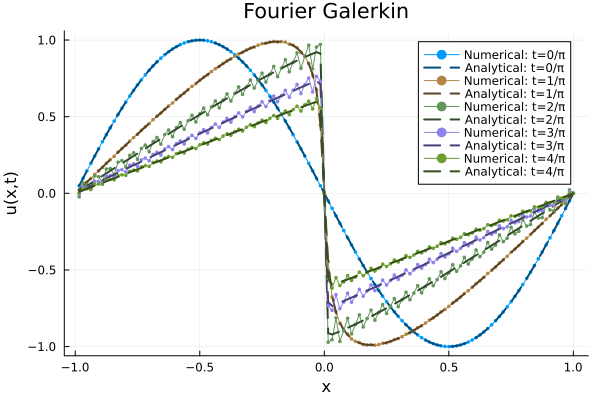

In [22]:
function plot_sol(method_name)
      plt = plot(title="$method_name", xlabel="x", ylabel="u(x,t)")
      pal = palette(:auto, length(snapshot_times))  # get default palette colors

      # Darken the analytical color by reducing brightness
      f = 0.5

      for (i, t) in enumerate(snapshot_times)
            num_color = pal[i]
            analytical_color = RGB(num_color.r * f, num_color.g * f, num_color.b * f)
            plot!(plt, x, snapshots[i], label="Numerical: t=$(i-1)/π", lw=1, color=num_color, marker=:circle, markersize=2, markerstrokewidth=0)
            plot!(plt, x, analytical_solution(x, t), label="Analytical: t=$(i-1)/π", lw=2, linestyle=:dash, color=analytical_color)
      end

      display(plt)
end

plot_sol("Fourier Galerkin")

We see that the numerical solution matches the analytical solution well, with oscillations due to the limited number of points used for the DFT. The oscillations are more pronounced around areas with large gradients, because Fourier basis functions are not well suited for representing discontinuous functions.

#### Fourier pseudospectral example

Same as above, but without dealiasing:

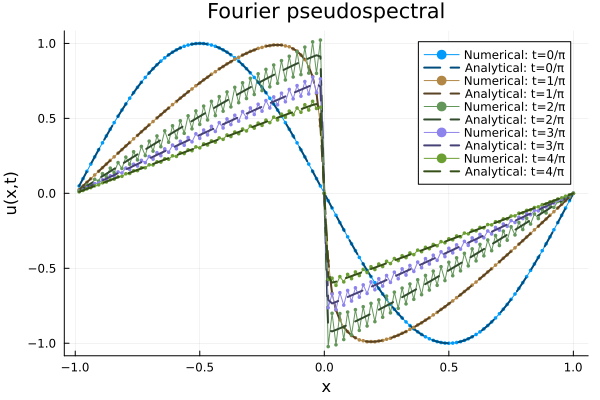

In [23]:
x, u_final, snapshot_times, snapshots = solveFourierSpectral(N; dt=dt, T=T, dt_snapshot=dt_snapshot, dealias_factor=1)
plot_sol("Fourier pseudospectral")

Higher-order oscillations are present in the solution, which is expected due to the aliasing errors introduced by using all Fourier modes.

#### Different grid spacings

A quick qualitative test of the effect of spatial and temporal grid spacings on the solution:

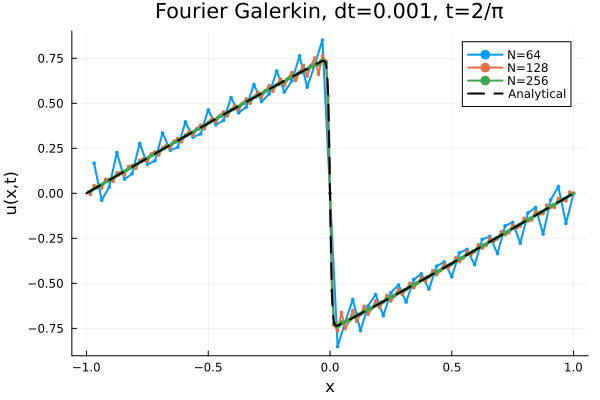

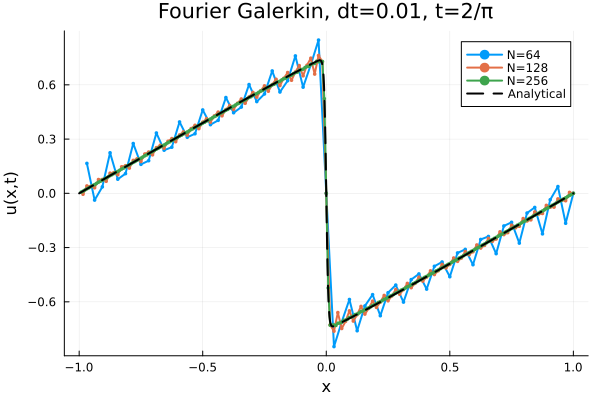

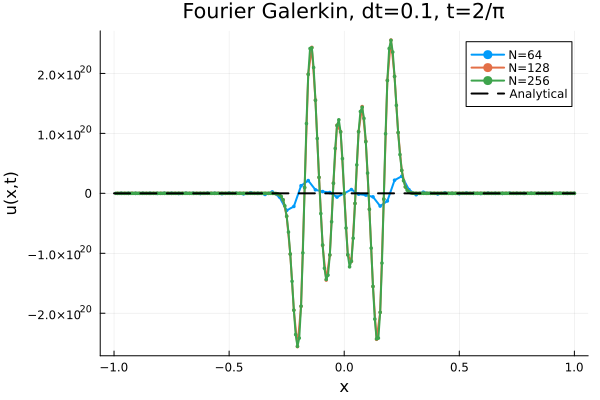

In [26]:
T = 3/pi
N_list = [64, 128, 256]
dt_list = [0.001, 0.01, 0.1]

for dt in dt_list
    plt = plot(title="Fourier Galerkin, dt=$dt, t=2/π", xlabel="x", ylabel="u(x,t)")
    for N in N_list
        x, u_final, _, _ = solveFourierSpectral(N; dt=dt, T=T, dealias_factor=(2)/3)
        plot!(plt, x, u_final, label="N=$N", lw=2, marker=:circle, markersize=2, markerstrokewidth=0)
    end
    x = range(-1, 1, length=1000)
    plot!(plt, x, analytical_solution(x, T), label="Analytical", lw=2, linestyle=:dash,color=:black)
    display(plt)
end

We see that the solution is more accurate for smaller spatial grid spacings (higher $N$), but oscillations are still present, albeit only at higher orders and smaller amplitudes. If the temporal grid spacing is too large, the solution becomes unstable and diverges.